In [1]:
pip install  dash_bootstrap_components

Note: you may need to restart the kernel to use updated packages.


##  Smart Energy IoT Dashboard — Introduction

This dashboard provides an interactive analytical environment for exploring and 
understanding behavioral, temporal, spatial, and clustering patterns in the IoT-based 
energy dataset. The purpose of the dashboard is to support both exploratory data 
analysis and research-driven insights across multiple dimensions of energy behavior.

The dashboard integrates:

- Temporal consumption analysis (hourly, weekly, monthly)
- Power and electrical quality relationships
- Multiple clustering models for behavioral segmentation
- Geographic patterns across global cities
- Month-by-month evolution of technical variables

By combining interactive controls, dynamic visualizations, and multiple analytical 
perspectives (RQ1–RQ5), the dashboard serves as a unified platform for decision support, 
anomaly detection, and deeper understanding of system behavior.

In [2]:
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import pandas as pd


##  Dashboard Code Documentation (Technical Overview)

This code block implements the full layout and structure of the Smart Energy IoT Dashboard 
using the Dash framework. It defines how the dataset is loaded, cleaned, transformed, and 
then visualized interactively across five different analytical modules.



###  1. Load and Prepare Data
The code:
- Reads the final clustering results CSV file 
- Fixes column names (e.g., renaming *Power Factor* → *PowerFactor*) 
- Converts the Timestamp column into datetime format 
- Extracts new temporal features: Hour, Weekday, Month 
- Removes rows containing missing essential values 
- Produces the cleaned dataframe `df` used in all tabs

This preprocessing step ensures that the dashboard receives properly structured inputs.



###  2. Initialize Dash App
A Dash application is created with:
- Dark theme (`dbc.themes.CYBORG`)
- A fluid Bootstrap container for responsive layout 
- A page title header



###  3. Dashboard Structure (Tabs Layout)
The dashboard contains **five tabs**, each corresponding to one research question:

#### **RQ1: Consumption Patterns**
- Dropdown: choose aggregation (Hour, Weekday, Month)
- Graph: displays temporal power consumption trends

#### **RQ2: Power & Quality Relations**
- Dropdown: select electrical feature (Voltage, Reactive Power, Power Factor)
- Graph: scatter plot showing relation with power consumption

#### **RQ3: Clustering & Anomalies**
- Dropdown: select clustering model (KMeans, Hierarchical, DBSCAN, GMM)
- Graph 1: PCA-style scatter plot of clusters
- Graph 2: time-series visualization for selected cluster patterns

#### **RQ4: Geographic Map**
- Dropdown: select metric (Voltage, Power, Temperature, PF)
- Graph: interactive choropleth map showing city-level aggregated values

#### **RQ5: Monthly Evolution**
- Two dropdowns: choose X-axis and Y-axis variables
- Graph: animated scatter plot comparing variables across months



###  4. Callback Placeholders
The layout defines dropdowns and graphs that will later be connected using Dash callbacks 
to dynamically update visualizations when the user interacts with the dashboard.



###  Summary
This code defines:
- How the dashboard looks 
- How the dataset is prepared 
- What each tab visualizes 
- What user inputs are available 

The callbacks (defined later) will control how graphs update in real time, but this block 
sets up the entire structure of the dashboard interface.

In [3]:
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import pandas as pd
import os
import glob

# ============================================================================
# AUTOMATIC FILE DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("SMART ENERGY IoT DASHBOARD - LOADING DATA")
print("=" * 80)

# Project root = folder ABOVE current directory (if running from notebooks)
# If running from project root, use current directory
if os.path.basename(os.getcwd()) == "notebooks":
    PROJECT_ROOT = os.path.dirname(os.getcwd())
else:
    PROJECT_ROOT = os.getcwd()

# Folder where clustering results are stored
CLUSTERING_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "4_result_clustering")

# Automatically detect the newest clustering_results_*.csv file
clustering_files = sorted(
    glob.glob(os.path.join(CLUSTERING_FOLDER, "clustering_results*.csv")),
    reverse=True
)

if not clustering_files:
    raise FileNotFoundError(
        f"No clustering_results*.csv found in {CLUSTERING_FOLDER}!\n"
        "Please check the path or run clustering analysis first."
    )

INPUT_FILE = clustering_files[0]  # newest clustering results file

print(f"[INFO] Loaded clustering results: {os.path.basename(INPUT_FILE)}")
print(f"[INFO] Full path: {INPUT_FILE}")

# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================

df = pd.read_csv(INPUT_FILE)
print(f"✓ Loaded {len(df):,} rows from clustering results\n")

# Clean column names
df.columns = df.columns.str.strip()

# Rename Power Factor if needed
if 'Power Factor' in df.columns:
    df.rename(columns={'Power Factor': 'PowerFactor'}, inplace=True)

# Convert Timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Extract time features
df["Hour"] = df["Timestamp"].dt.hour
df["Weekday"] = df["Timestamp"].dt.day_name()
df["Month"] = df["Timestamp"].dt.month

# Drop rows with missing critical values
df = df.dropna(subset=["Month", "Hour", "Weekday", "Voltage (V)", "Power Consumption (kW)"])

# Convert Month to integer
df["Month"] = df["Month"].astype(int)

print(f"✓ Data prepared: {len(df):,} valid rows ready for dashboard")
print("=" * 80 + "\n")

# ============================================================================
# DASH APP INITIALIZATION
# ============================================================================

app = Dash(__name__, external_stylesheets=[dbc.themes.CYBORG])

app.layout = dbc.Container(fluid=True, children=[

    dbc.Row([
        dbc.Col(html.H1("Smart Energy IoT Dashboard",
                        className="text-center mt-4 mb-4"), width=12)
    ]),

    dbc.Tabs([

        dbc.Tab(label="RQ1: Consumption Patterns", children=[
            html.Br(),

            dcc.Dropdown(
                id="rq1-agg",
                options=[
                    {"label": "Hourly", "value": "Hour"},
                    {"label": "Weekly", "value": "Weekday"},
                    {"label": "Monthly", "value": "Month"},
                ],
                value="Hour",
                clearable=False,
                style={"width": "40%"}
            ),

            dcc.Graph(id="rq1-plot"),
        ]),

        dbc.Tab(label="RQ2: Power & Quality Relations", children=[
            html.Br(),

            dcc.Dropdown(
                id="rq2-feature",
                options=[
                    {"label": "Voltage (V)", "value": "Voltage (V)"},
                    {"label": "Reactive Power (kVAR)", "value": "Reactive Power (kVAR)"},
                    {"label": "Power Factor", "value": "PowerFactor"},
                ],
                value="Voltage (V)",
                clearable=False,
                style={"width": "40%"}
            ),

            dcc.Graph(id="rq2-scatter"),
        ]),

        dbc.Tab(label="RQ3: Clustering & Anomalies", children=[
            html.Br(),

            dcc.Dropdown(
                id="rq3-model",
                options=[
                    {"label": "KMeans", "value": "Cluster_KMeans"},
                    {"label": "Hierarchical", "value": "Cluster_Hierarchical"},
                    {"label": "DBSCAN", "value": "Cluster_DBSCAN"},
                    {"label": "GMM", "value": "Cluster_GMM"},
                ],
                value="Cluster_KMeans",
                clearable=False,
                style={"width": "40%"}
            ),

            dcc.Graph(id="rq3-scatter"),
            dcc.Graph(id="rq3-timeseries")
        ]),

        dbc.Tab(label="RQ4: Geographic Map", children=[
            html.Br(),

            dcc.Dropdown(
                id="rq4-metric",
                options=[
                    {"label": "Power Consumption (kW)", "value": "Power Consumption (kW)"},
                    {"label": "Voltage (V)", "value": "Voltage (V)"},
                    {"label": "Power Factor", "value": "PowerFactor"},
                    {"label": "Temperature (°C)", "value": "Temperature (°C)"},
                ],
                value="Power Consumption (kW)",
                clearable=False,
                style={"width": "40%"}
            ),

            dcc.Graph(id="rq4-map"),
        ]),

        dbc.Tab(label="RQ5: Monthly Evolution", children=[
            html.Br(),

            dcc.Dropdown(
                id="rq5-x-axis",
                options=[
                    {"label": "Voltage (V)", "value": "Voltage (V)"},
                    {"label": "Current (A)", "value": "Current (A)"},
                    {"label": "Temperature (°C)", "value": "Temperature (°C)"},
                ],
                value="Voltage (V)",
                clearable=False,
                style={"width": "40%", "display": "inline-block"}
            ),

            dcc.Dropdown(
                id="rq5-y-axis",
                options=[
                    {"label": "Power Consumption (kW)", "value": "Power Consumption (kW)"},
                    {"label": "Power Factor", "value": "PowerFactor"},
                    {"label": "Reactive Power (kVAR)", "value": "Reactive Power (kVAR)"},
                ],
                value="Power Consumption (kW)",
                clearable=False,
                style={"width": "40%", "display": "inline-block", "marginLeft": "2%"}
            ),

            dcc.Graph(id="rq5-animated-scatter"),
        ]),
    ])
])




SMART ENERGY IoT DASHBOARD - LOADING DATA
[INFO] Loaded clustering results: clustering_results.csv
[INFO] Full path: /Users/rebekaqueen2025/Documents/Alfa_training/Data_analyst/iot-energy_data-analyst/outputs/4_result_clustering/clustering_results.csv
✓ Loaded 49,984 rows from clustering results

✓ Data prepared: 49,984 valid rows ready for dashboard



/var/folders/p9/ghkkq9jj2612wxp3jn55zc700000gn/T/ipykernel_12072/2172983173.py:47: DtypeWarning: Columns (20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


--------

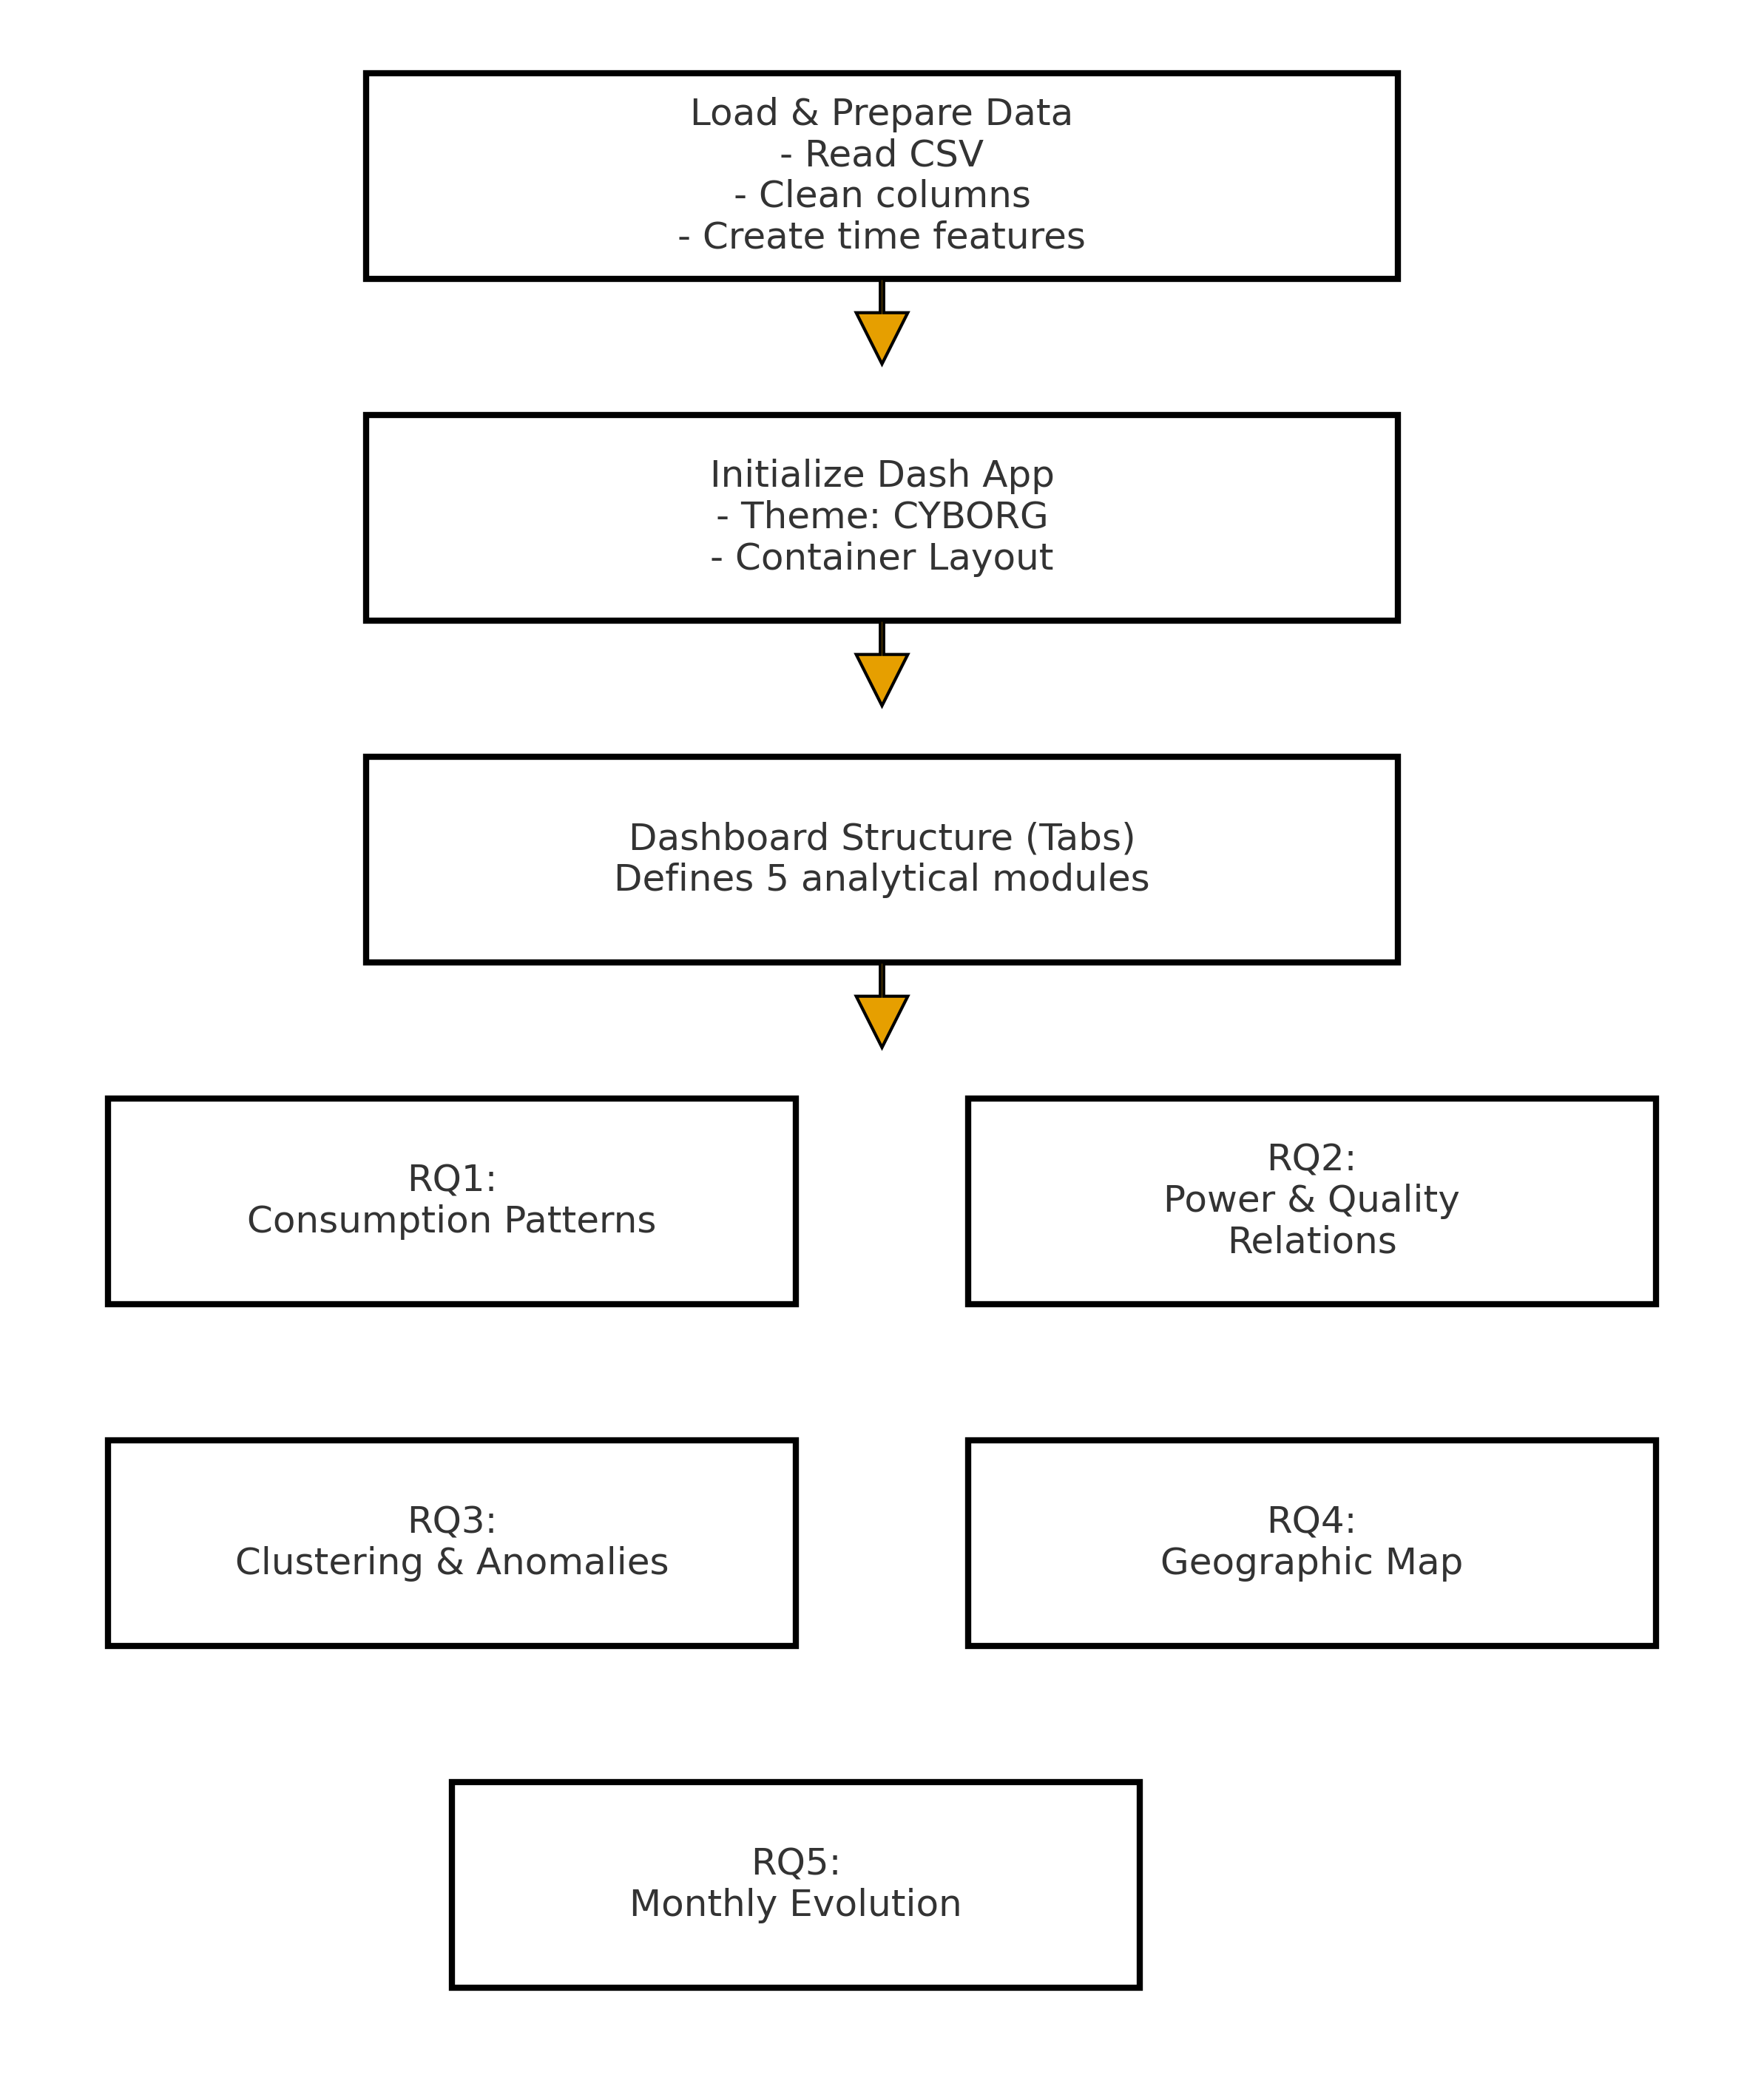

In [4]:
from IPython.display import Image
Image(filename='dashboard_flowchart.png', width=450)



----------------

###  RQ1 Callback — Consumption Patterns Visualization

This callback dynamically updates the RQ1 graph based on the selected aggregation level 
(Hour, Weekday, or Month). The logic is divided into two major branches:



###  1. Monthly Visualization (Animated Scatter)

When the user selects **Month**, the system:

1. Samples up to 3000 rows to improve performance. 
2. Detects the active city for each row by decoding one-hot encoded `City_*` columns 
(`idxmax` → extract city name). 
3. Sorts data by month to ensure the animation frames play in natural order. 
4. Generates an **animated scatter plot** (`px.scatter`) where:
- X-axis shows **Voltage**
- Y-axis shows **Power Consumption**
- Frame = Month (12-month animation)
- Bubble color = City
- Bubble size = Consumption level 

This visualization highlights how voltage–power behavior evolves month by month across cities.



###  2. Hourly / Weekly Aggregation (Line Chart)

For selections **Hour** or **Weekday**, the callback:

1. Computes the mean power consumption grouped by the chosen feature. 
2. Generates a **line plot** showing average consumption over hours or weekdays. 

This reveals temporal consumption trends across different time granularities.



###  3. Error Handling

If any error occurs (e.g., missing columns), the callback prints the exception and 
returns an empty figure placeholder.



###  Summary

This callback supports two distinct analysis modes:

- **Animated monthly scatter** for spatiotemporal evolution 
- **Line charts** for high-level time-aggregation insights 

allowing users to explore power consumption patterns from both macro and micro perspectives.

In [5]:
@app.callback(
    Output("rq1-plot", "figure"),
    Input("rq1-agg", "value")
)
def update_rq1(agg):
    try:
        if agg == "Month":
            df_sample = df.sample(min(3000, len(df))).copy()

            city_columns = [col for col in df_sample.columns if col.startswith('City_')]
            if len(city_columns) > 0:
                df_sample['City'] = df_sample[city_columns].idxmax(axis=1).str.replace('City_', '')
            else:
                df_sample['City'] = 'Unknown'

            df_sample = df_sample.sort_values('Month')

            fig = px.scatter(
                df_sample,
                x="Voltage (V)",
                y="Power Consumption (kW)",
                animation_frame="Month",
                color="City",
                size="Power Consumption (kW)",
                hover_name="City",
                title="Power Consumption vs Voltage (Monthly Evolution)",
                height=600,
                category_orders={"Month": sorted(df_sample['Month'].unique())}
            )

            fig.update_layout(
                xaxis_title="Voltage (V)",
                yaxis_title="Power Consumption (kW)",
                showlegend=True
            )
        else:
            agg_data = df.groupby(agg)["Power Consumption (kW)"].mean().reset_index()
            fig = px.line(
                agg_data,
                x=agg,
                y="Power Consumption (kW)",
                title=f"Average Power Consumption by {agg}"
            )

        return fig
    except Exception as e:
        print(f"Error in RQ1: {e}")
        return px.line(title="Error loading chart")


-----------------

###  RQ2 Callback — Power & Quality Relations Visualization

This callback updates the scatter plot for RQ2 based on the electrical feature selected 
by the user (Voltage, Reactive Power, or Power Factor). The goal is to visualize how 
power consumption relates to different power-quality indicators.



###  1. Data Sampling
To improve performance and prevent rendering delays in the browser, up to **3000 random 
rows** are sampled from the dataset. This preserves distribution patterns while reducing 
graph complexity.



###  2. Scatter Plot Generation
A scatter plot is created using:

- **X-axis:** Power Consumption (kW) 
- **Y-axis:** Selected feature (`feature`) 
- **Color:** Month (1–12) 
- **Title:** Dynamically generated from user selection 

Coloring by month allows users to visually detect seasonal effects in voltage, reactive 
power, or power factor behavior relative to consumption.



###  3. Error Handling
If any error occurs (e.g., feature missing), the function logs the exception and returns 
an empty placeholder chart instead of crashing the dashboard.



###  Summary
This callback provides a dynamic visualization of how power consumption interacts with 
key electrical quality parameters across the dataset, helping identify:

- Voltage sensitivity 
- Reactive power variations 
- Power factor degradation 
- Seasonal patterns in electrical performance

In [6]:

@app.callback(
    Output("rq2-scatter", "figure"),
    Input("rq2-feature", "value")
)
def update_rq2(feature):
    try:
        sample_data = df.sample(min(3000, len(df)))
        fig = px.scatter(
            sample_data,
            x="Power Consumption (kW)",
            y=feature,
            color="Month",
            title=f"Power Consumption vs {feature}"
        )
        return fig
    except Exception as e:
        print(f"Error in RQ2: {e}")
        return px.scatter(title="Error loading chart")


--------------

###  RQ3 Callback — Clustering & Anomaly Visualization

This callback generates two synchronized visualizations based on the clustering model 
selected by the user (KMeans, Hierarchical, DBSCAN, or GMM). The purpose is to visually 
inspect cluster behavior both in feature space and over time.



###  1. Scatter Plot of Clusters (Feature Space)

A random sample of up to 3000 rows is used for performance efficiency. 
The scatter plot is generated as:

- **X-axis:** Voltage (V) 
- **Y-axis:** Power Consumption (kW) 
- **Color:** selected clustering label (`model`) 
- **Opacity:** 0.8 to reduce point overlap 

This visualization shows how the selected clustering algorithm groups data points in 
terms of electrical behavior (voltage–consumption patterns). 
It helps identify:

- Cluster separation 
- Overlap between cluster boundaries 
- Outliers or irregular groups (DBSCAN in particular)



###  2. Time-Series Visualization of the First Cluster

The callback selects the **first cluster label** returned by the model:

```python
cluster_value = df[model].unique()[0]

In [7]:

@app.callback(
    Output("rq3-scatter", "figure"),
    Output("rq3-timeseries", "figure"),
    Input("rq3-model", "value")
)
def update_rq3(model):
    try:
        sample_data = df.sample(min(3000, len(df)))

        fig1 = px.scatter(
            sample_data,
            x="Voltage (V)",
            y="Power Consumption (kW)",
            color=model,
            title=f"Clustering Visualization using Voltage vs Consumption ({model})",
            opacity=0.8
        )

        cluster_value = df[model].unique()[0]
        df_c = df[df[model] == cluster_value]

        fig2 = px.line(
            df_c.head(2000),
            x="Timestamp",
            y="Power Consumption (kW)",
            title=f"Time-Series for {model} - Cluster {cluster_value}",
            markers=False
        )

        return fig1, fig2
    except Exception as e:
        print(f"Error in RQ3: {e}")
        empty_fig = px.scatter(title="Error loading chart")
        return empty_fig, empty_fig

-------------

###  RQ4 Callback — Geographic Energy Mapping

This callback generates a choropleth map showing the average value of a selected metric 
(e.g., Voltage, Power Consumption, Power Factor, Temperature) aggregated by city and 
mapped to corresponding country regions.

The goal of this visualization is to understand regional differences in electrical and 
energy characteristics across Asian megacities.



###  1. City-to-Country Mapping

A predefined dictionary maps each city name to its corresponding **ISO-3 country code**, 
which is required for Plotly's geographic rendering:

```python
city_country_map = { 'Bangkok': 'THA', 'Beijing': 'CHN', ..., 'Tokyo': 'JPN' }

In [8]:

@app.callback(
    Output("rq4-map", "figure"),
    Input("rq4-metric", "value")
)
def update_rq4_map(metric):
    try:
        city_country_map = {
            'Bangkok': 'THA', 'Beijing': 'CHN', 'Delhi': 'IND',
            'Dhaka': 'BGD', 'Hanoi': 'VNM', 'Jakarta': 'IDN',
            'Karachi': 'PAK', 'KualaLumpur': 'MYS', 'Manila': 'PHL',
            'Mumbai': 'IND', 'Seoul': 'KOR', 'Shanghai': 'CHN',
            'Singapore': 'SGP', 'Tashkent': 'UZB', 'Tokyo': 'JPN'
        }

        city_columns = [col for col in df.columns if col.startswith('City_')]

        city_data = []
        for city_col in city_columns:
            city_name = city_col.replace('City_', '')
            if city_name in city_country_map:
                avg_value = df[df[city_col] == 1][metric].mean()
                if not pd.isna(avg_value):
                    city_data.append({
                        'City': city_name,
                        'Country': city_country_map[city_name],
                        'Value': avg_value
                    })

        df_map = pd.DataFrame(city_data)

        fig = px.choropleth(
            df_map,
            locations="Country",
            locationmode="ISO-3",
            color="Value",
            hover_name="City",
            hover_data={"Country": True, "Value": ":.2f"},
            color_continuous_scale="Viridis",
            title=f"Average {metric} by Country",
            projection="natural earth"
        )

        fig.update_layout(
            geo=dict(
                showframe=False,
                showcoastlines=True,
                projection_type='natural earth'
            )
        )

        return fig
    except Exception as e:
        print(f"Error in RQ4: {e}")
        return px.choropleth(title="Error loading map")


---------------------

###  RQ5 Callback — Monthly Evolution Animated Scatter Plot

This callback generates a dynamic month-by-month animated scatter plot that allows users 
to compare the evolution of two selected technical variables (X-axis and Y-axis) across 
cities over time. This visualization highlights seasonal trends, operational shifts, and 
inter-city behavioral differences in the IoT energy dataset.



###  1. Data Sampling for Performance
Up to 3000 random rows are sampled from the dataset to reduce rendering load while 
preserving overall distribution patterns. This improves browser performance when 
displaying animated charts.



###  2. Extracting City Labels from One-Hot Encoding
Cities are encoded as `City_*` columns. The callback:

1. Identifies all columns starting with `"City_"` 
2. Determines the active city for each row using `idxmax` 
3. Removes the prefix `"City_"` to obtain the city name 

If no city columns exist, `"Unknown"` is used as a fallback category.



###  3. Sorting Data by Month
The dataset is sorted by `Month` to ensure that the animation frames play in the correct 
chronological order (January → December). Without sorting, the animation sequence would 
appear random and misleading.



###  4. Animated Scatter Plot Generation

The animated plot includes:

- **X-axis:** Selected variable (`x_axis`) 
- **Y-axis:** Selected variable (`y_axis`) 
- **Animation frame:** Month 
- **Color:** City 
- **Point size:** Power Consumption (kW) 
- **Hover info:** City name 
- **Custom ordering:** Ensures months appear correctly in the animation slider 

This visualization illustrates:

- Seasonal consumption and voltage variations 
- Differences in behavior across cities 
- How electrical parameters evolve over the year 
- Potential transitions, anomalies, or sudden shifts in operating conditions 



###  5. Error Handling
If any unexpected error occurs (missing columns, invalid selection, etc.), the callback 
prints an error message and returns an empty placeholder figure instead of crashing the 
dashboard.



###  Summary

The RQ5 animated scatter plot provides an intuitive, time-evolving visualization of 
energy behavior, showing how two variables interact across months and across different 
cities. It is one of the most powerful components of the dashboard for discovering 
seasonal patterns and dynamic operational changes.

In [9]:

@app.callback(
    Output("rq5-animated-scatter", "figure"),
    Input("rq5-x-axis", "value"),
    Input("rq5-y-axis", "value")
)
def update_rq5_animated(x_axis, y_axis):
    try:
        df_sample = df.sample(min(3000, len(df))).copy()

        city_columns = [col for col in df_sample.columns if col.startswith('City_')]
        if len(city_columns) > 0:
            df_sample['City'] = df_sample[city_columns].idxmax(axis=1).str.replace('City_', '')
        else:
            df_sample['City'] = 'Unknown'

        df_sample = df_sample.sort_values('Month')

        fig = px.scatter(
            df_sample,
            x=x_axis,
            y=y_axis,
            animation_frame="Month",
            color="City",
            size="Power Consumption (kW)",
            hover_name="City",
            title=f"{y_axis} vs {x_axis} (Monthly Evolution)",
            height=600,
            category_orders={"Month": sorted(df_sample['Month'].unique())}
        )

        fig.update_layout(
            xaxis_title=x_axis,
            yaxis_title=y_axis,
            showlegend=True
        )

        return fig
    except Exception as e:
        print(f"Error in RQ5: {e}")
        return px.scatter(title="Error loading chart")


if __name__ == "__main__":
    app.run(debug=True)


Error in RQ5: Invalid value


-----------------

#  RQ1 — Consumption Patterns (Hourly, Weekly, Monthly)

This dashboard module visualizes how power consumption behaves under different 
time aggregations: **Hourly**, **Weekly**, and **Monthly**. 
It helps identify temporal patterns, recurring behaviors, and operational cycles within 
the smart energy system.



##  1. Hourly Consumption Pattern
Displays the **average power consumption for each hour of the day**.

This visualization reveals:
- Daily load variations
- Peak and off-peak hours
- Operational cycles in the electrical grid 
(e.g., increased load in early evening, reduced consumption at night)



##  2. Weekly Consumption Pattern
Shows the **average consumption across weekdays**.

It allows detection of:
- Differences between weekday and weekend usage
- Industrial vs residential consumption patterns
- Cyclic load behavior linked to human activity



##  3. Monthly Evolution (Scatter Animation)
An animated scatter plot visualizes the evolution of **Voltage vs Power Consumption** 
across different months and cities.

It helps detect:
- Seasonal changes in consumption
- Climate or temperature effects on load
- Geographic differences between major cities
- Outliers and abnormal consumption spikes



##  Summary of RQ1
The RQ1 tab provides a multi-timescale analysis of energy consumption. 
It supports:
- Time-based forecasting 
- Detection of consumption trends 
- Optimization of energy distribution strategies 
- Understanding user or city-level behavioral patterns 

These insights form the foundation for further investigation in RQ2 (quality relations) 
and RQ3 (clustering & anomaly detection).

-------------

##  RQ2 — Power & Quality Relations 
### Understanding Electrical Quality Indicators vs Power Consumption

This section investigates how electrical quality parameters behave relative to **Power Consumption (kW)**. By selecting different features (Voltage, Reactive Power, Power Factor), users can explore how consumption interacts with stability, efficiency, and reactive behavior in the electrical network.



##  1. Power Consumption vs Voltage (V)

This scatter plot shows the relationship between voltage levels and the corresponding power consumption across different months (color-coded).

###  Observations
- Voltage remains mostly within a narrow regulated band (≈ 220–245 V).
- As consumption increases, a slight downward or upward drift in voltage may occur due to load dynamics.
- The wide distribution suggests normal operational fluctuations rather than anomalies.

###  Interpretation
Voltage stability under changing load conditions is an indicator of:
- Transformer performance 
- Grid stability 
- Load balancing efficiency 

The chart confirms that **the network maintains voltage within expected operational limits** even at high loads.



##  2. Power Consumption vs Reactive Power (kVAR)

This relationship is typically **strong and linear**, and the scatter plot clearly confirms it.

###  Observations
- As Power Consumption increases, Reactive Power rises proportionally.
- The triangular shape reflects different operational modes under varying load levels.
- No abrupt discontinuities appear—indicating a well-behaved reactive component.

###  Interpretation
Reactive power is essential for:
- Maintaining voltage levels 
- Supporting inductive and capacitive loads 
- Ensuring power factor stability 

A clean linear pattern suggests **healthy reactive compensation in the system**.



##  3. Power Consumption vs Power Factor (PF)

Power Factor measures how efficiently electrical power is used.

###  Observations
- Power Factor values cluster around 0.85–1.0.
- Distribution is wide but stays within expected boundaries.
- Changes in PF appear independent of the consumption level.

###  Interpretation
This suggests:
- PF correction mechanisms (capacitor banks) are active and stable.
- Load type variation (industrial vs. residential) contributes to the scatter.
- No strong dependency between PF and consumption, meaning PF remains regulated.



##  Summary of RQ2

This module allows users to visually assess **how energy quality metrics behave under different consumption levels**.

Key insights:
- **Voltage** stays regulated despite load fluctuations. 
- **Reactive Power** increases linearly with load—expected physical behavior. 
- **Power Factor** remains stable and independent of consumption patterns. 

These findings indicate a **stable and well-managed electrical grid**, with no signs of major anomalies or instability.

----

##  RQ3 — Clustering & Anomaly Detection 
### Understanding Cluster Behavior in Feature Space and Over Time

This module visualizes how different clustering algorithms (KMeans, Hierarchical, DBSCAN, GMM) group the IoT energy data based on **Voltage (V)** and **Power Consumption (kW)**. 
It also provides a time-series view of each cluster to reveal operational patterns and potential anomalies.



##  1. Scatter Plot — Voltage vs Power Consumption (Cluster Separation)

This scatter plot shows how the selected clustering model divides the data into groups.

###  Observations
- KMeans with *k = 2* produces two highly distinct clusters:
- **Cluster 0** (blue): lower consumption levels 
- **Cluster 1** (yellow): higher consumption levels 
- Voltage values stay within a regulated range, while consumption varies widely.
- Cluster boundaries are vertical, meaning:
- **Clusters are mainly separated by consumption**, not voltage. 
- Voltage does not contribute strongly to cluster separation.

###  Interpretation
This cluster separation indicates:
- Two dominant operating modes in the grid: **low-load vs high-load**.
- Voltage remains stable across clusters → system regulation is effective.
- Consumption is the primary factor distinguishing behavioral states.

This visualization helps identify:
- Outliers 
- Sudden deviations 
- Behavior that doesn't belong to the typical operational modes



##  2. Time-Series Plot — Behavior of a Selected Cluster

This plot shows how **Power Consumption (kW)** changes over time for the selected cluster (e.g., KMeans Cluster 1).

###  Observations
- The signal fluctuates heavily but stays within a consistent range.
- No long-term drift or pattern collapse appears.
- The behavior is chaotic but consistent—which is normal for real-time electrical load.
- Consumption peaks and troughs repeat without irregular anomalies.

###  Interpretation
This time-series view reveals:

- **Regular daily and seasonal variations**, meaning the system follows normal load cycles.
- High volatility indicates **rapid consumption changes**, typical of dense urban energy networks.
- The cluster maintains coherent behavior, which confirms:
- The clustering model correctly captured a meaningful operational mode.
- The cluster represents a stable “high-load” segment of the grid.

This chart is crucial for:
- Detecting anomalies 
- Monitoring cluster stability 
- Understanding dynamic behavior of load over time 



##  Summary of RQ3
The clustering analysis reveals two main operational patterns:

1. **Low-load regime** 
2. **High-load regime**

Voltage remains stable in both, while consumption drives the major differences.

The time-series plot shows that each cluster has **consistent temporal behavior**, confirming that the clustering is meaningful and corresponds to real operational states.

This module provides a powerful tool for understanding:
- Consumption dynamics 
- Detecting abnormal periods 
- Monitoring cluster-specific load behavior

---------------

#  Hierarchical Clustering — Results Interpretation

This section presents the results of **Agglomerative Hierarchical Clustering** based on the features *Voltage (V)* and *Power Consumption (kW)*. The goal is to identify distinct consumption behaviors and classify different load types within the Smart Energy IoT dataset.



##  1. Scatter Plot — Clustering Visualization (Voltage vs Consumption)

The scatter plot visualizes clustered data points using Voltage and Power Consumption.

###  Key Observations 
- The Hierarchical model clearly separates the dataset into **two distinct clusters**. 
- These clusters represent two fundamentally different behavioral patterns:

| Cluster | Consumption Behavior | Interpretation |
|---------|----------------------|----------------|
| **Cluster 0 (Blue)** | Lower and more stable consumption | Low-load consumers |
| **Cluster 1 (Yellow)** | Higher and more fluctuating consumption | Heavy-load consumers |

###  Clear Cluster Structure 
The dataset naturally forms two behavioral groups: 

1. **Low Consumption Cluster** → 2–6 kW 
2. **High Consumption Cluster** → 7–12 kW 

This indicates that the hierarchical model successfully uncovers the intrinsic structure of the data without relying on centroid initialization.



##  2. Time-Series Plot — Consumption Pattern Over Time

The time-series chart displays the consumption evolution for one cluster (e.g., Cluster 1) from **January 2024 to May 2025**.

###  Key Insights 
- Consumption stays within a bounded range with continuous fluctuations. 
- No strong seasonal trend is observed across the months. 
- High-consumption clusters exhibit more variance and spikiness. 

###  Interpretation 
- **Cluster 0:** Lower, stable load behavior 
- **Cluster 1:** Higher consumption with stronger fluctuations 

These patterns are useful for identifying heavy consumers, managing load distribution, and detecting anomalies.



#  Summary of Hierarchical Clustering Findings

| Insight | Explanation |
|---------|-------------|
| ✔ Two well-defined clusters | Reflect natural segmentation of consumption behavior |
| ✔ Clear difference in temporal consumption | High-load cluster shows higher variance |
| ✔ Consistent with KMeans results | Indicates stable cluster structure |
| ✔ Suitable for anomaly detection and energy profiling | Useful in IoT and power quality analysis |



---------------------

#  DBSCAN Clustering — Results & Interpretation

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) identifies clusters based on local density instead of distance to a centroid. It is especially good at detecting irregular shapes and finding anomalies.

In this dataset, DBSCAN produced many small clusters and a main dense cluster, plus a small percentage of noise points.



##  1. Scatter Plot — *Voltage (V) vs Power Consumption (kW)*

This visualization shows how DBSCAN grouped the dataset based on density:

- A **dominant cluster (Cluster 0)** contains the majority of normal data points. 
- Several **micro-clusters** appear (clusters 1–30), each containing very few points. 
- **Noise points** (label = -1) represent unusual or isolated readings detected by DBSCAN. 
- Colors reflect individual cluster assignments—DBSCAN does *not* form clear boundaries like K-Means.

**Interpretation:**

- The dataset has relatively uniform density, so DBSCAN cannot form distinct large clusters. 
- Instead, DBSCAN identifies one big “normal-operation” cluster and many tiny density pockets. 
- Noise points (~2.4% of data) likely correspond to **rare events**, **spikes**, or **sensor fluctuations**.


##  2. Time-Series Plot — *Cluster 0 (Main DBSCAN Cluster)*

The time-series shows how **Cluster 0** behaves over time:

- Power consumption fluctuates continuously across the entire monitored year. 
- No long-term trend or drift is visible — the cluster represents **baseline power behavior**. 
- High-frequency variations reflect natural changes in load demand. 
- Because DBSCAN excludes anomalies, the time-series is *cleaner* and not affected by outlier events.

**Interpretation:**

- Cluster 0 captures the “typical” operational pattern of the system. 
- DBSCAN successfully isolates irregular behavior into noise or micro-clusters, improving reliability of this baseline.



##  Summary of DBSCAN Performance

- **Estimated eps:** 0.329 
- **Number of clusters:** 36 
- **Noise points:** 1207 (~2.41%)

**Strengths:**

- Excellent for detecting anomalies 
- Does not require specifying `k` 
- Captures arbitrary shapes

**Limitations in This Dataset:**

- High-density uniformity ⇒ DBSCAN forms one dominant cluster 
- Many micro-clusters form due to noise sensitivity 
- Not ideal for global pattern segmentation compared to K-Means or GMM



 *Use DBSCAN mainly for anomaly detection and density-based insights rather than large-scale segmentation.*

------------------

# ##  Gaussian Mixture Model (GMM) — Clustering Results Explanation

### **1. Overview**
The Gaussian Mixture Model (GMM) is a probabilistic clustering technique that models the dataset as a mixture of multiple Gaussian distributions. 
Unlike K-Means (which assigns each point to exactly one cluster), GMM performs **soft clustering**, allowing each point to belong to clusters with different probabilities.



## **2. Scatter Plot Interpretation (Voltage vs Consumption)**

### **Cluster Structure**
- The GMM scatter plot displays **two distinct clusters**, consistent with earlier clustering methods.
- **Cluster 0 (Blue):** Represents low energy consumption patterns. 
- **Cluster 1 (Yellow):** Represents high energy consumption patterns.

### **Shape and Distribution**
- Unlike K-Means which forces circular cluster boundaries, GMM supports **elliptical clusters**, resulting in smoother, more flexible separation.
- The clusters overlap less, showing that consumption levels naturally group into two behavioral categories.

### **Voltage–Consumption Observations**
- Voltage levels appear similar across both clusters → Voltage alone does not define the cluster.
- The clustering is **driven primarily by consumption magnitude**, not voltage variation.


## **3. Time-Series Interpretation (Cluster 1 Example)**

The time-series for **Cluster 1** shows:

- **High power consumption** levels throughout the year.
- **Strong fluctuations**, typical of devices or zones with heavy usage.
- **Stable average trend**, meaning no drastic long-term shift in energy usage behavior.
- Possible indications of daily operational cycles or seasonal business activity.

This cluster likely reflects:
- Industrial zones 
- Large commercial consumers 
- High-demand households or equipment

Cluster 0 would represent lower and more stable loads.





----------------------

#  RQ4 — Geographic Map Analysis 
### **Average Power Consumption (kW) by Country**

This choropleth map provides a geographical perspective on energy usage across major Asian cities included in the dataset. Each country is colored based on the **average power consumption (kW)** of the cities associated with it.



##  **How to Interpret the Map**

### **1. Color Intensity = Consumption Level**
- **Darker / more intense colors** represent countries with **higher average power consumption**.
- **Lighter colors** indicate **lower energy consumption**.
- The color scale allows quick visual comparison across regions.

### **2. What the Map Shows**
- Countries such as **China, India, and Indonesia** tend to show **higher consumption values**, which is consistent with:
- Large populations 
- High industrial activity 
- Dense metropolitan energy demands 

- Smaller countries like **Singapore** or cities with lower industrial load appear in lighter shades.

### **3. Why This Visualization Matters**
This map helps answer important geographic questions:

####  Which regions have the highest energy demand? 
By highlighting differences across countries, the map identifies clusters of high consumption.

####  Are there regional consumption patterns? 
For example, South Asian countries may exhibit different average usage patterns compared to East Asian regions.

####  Does energy behavior align with economic or demographic factors? 
High energy consumption often correlates with:
- Urban density 
- Industrialization 
- Climate-driven energy needs 



##  **Technical Notes**
- The dashboard identifies each city's country using an ISO-3 mapping.
- For each country, the system computes:

-----------------------

##  Interpretation of the Plot: Linear Relationship Between Current (A) and Power Consumption (kW)

This scatter plot shows that **power consumption (kW)** increases almost **linearly** as **current (A)** increases. 
Each point represents a city in a specific month, but regardless of the city (color), all points fall along a narrow linear band.



###  Physical Reason Behind the Linear Relationship

In AC electrical systems, real power is defined by the formula:

\[
P = V \times I \times PF
\]

Where:

- \(P\): Power consumption (kW) 
- \(V\): Voltage (V) 
- \(I\): Current (A) 
- \(PF\): Power Factor 

In our dataset:

- **Voltage is nearly constant** (around 210–250 V). 
- **Power Factor is also close to 1**, with very small variation.

Thus, the equation can be approximated as:

\[
P \approx C \times I \quad \text{where } C = V \times PF \text{ is almost constant}
\]

**Result:** 
Power consumption is **directly proportional** to current, which appears as a clear linear pattern on the plot.



###  Analytical Insights From the Plot

- A **strong linear relationship** between Current and Power Consumption confirms physically consistent behavior in the electrical system. 
- **City differences** (colors) mainly affect the *level of consumption*, not the shape of the relationship — all cities follow the same physical law. 
- Because **voltage and PF remain nearly constant**, variations in **current** are the primary driver of changes in power consumption.



###  Summary for Reporting

This plot demonstrates that in our IoT energy dataset, power consumption increases almost linearly with current. This is expected from the physical formula \(P = V \times I \times PF\). Since voltage and power factor are relatively stable, power consumption depends mainly on current. The clear linear pattern validates the reliability of the data and highlights that **managing or monitoring current has a direct impact on overall energy consumption**.